# Fine Tuning

Feature extraction transfer learning vs. fine-tuning transfer learning. The main difference between the two is that in fine-tuning, more layers of the pre-trained model get unfrozen and tuned on custom data. This fine-tuning usually takes more data than feature extraction to be effective.

In [4]:
!nvidia-smi

Mon May  2 17:37:49 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   74C    P0    73W / 149W |    207MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Import helper functions

In [5]:
# Get helper_functions.py script from course GitHub
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py 

# Import helper functions we're going to use
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir

--2022-05-02 17:37:49--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-05-02 17:37:49 (45.7 MB/s) - ‘helper_functions.py’ saved [10246/10246]



## Section 1: 10 Food classes with 10% data

In [6]:
# Get 10% of the data of the 10 classes
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip 

unzip_data("10_food_classes_10_percent.zip")

--2022-05-02 17:37:50--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.152.128, 173.194.193.128, 173.194.194.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.152.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   171MB/s    in 0.9s    

2022-05-02 17:37:51 (171 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [7]:
# Create training and test directories
train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

In [8]:
# Create data inputs
import tensorflow as tf
IMG_SIZE = (224, 224)
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                                                                            image_size=IMG_SIZE,
                                                                            label_mode="categorical",
                                                                            batch_size=32) # batch_size default is 32
test_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                                           image_size=IMG_SIZE,
                                                                           label_mode="categorical")

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [9]:
# Check the training data datatype
train_data_10_percent

<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

In [10]:
# Check out the class names of our dataset
train_data_10_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

## Model 0 :Building a transfer learning model using the Keras Functional API

In [12]:
# 1. Create base model with tf.keras.applications
import tensorflow as tf
base_model = tf.keras.applications.EfficientNetB0(include_top=False)

# 2. Freeze the base model
base_model.trainable = False

# 3. Create inputs into the base model
inputs = tf.keras.layers.Input(shape=(224, 224,3))

# 4. If using ResNet50V2, add this to speed up convergence, remove EfficientNet
# x = tf.keras.layers.experimental.preporcessing.Rescaling (1./255)(inputs)

# 5. Pass the inputs to the base_model (using tf.keras.applications, EfficientNet inputs don't have to be normalized)
x = base_model(inputs)
# Check data shape after passing it to base_model
print(f"Shape after base_model: {x.shape}")

# 6. Average pool the outputs of the base model (aggregate all the most important information, reduce number of computations)
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
print(f"After GlobalAveragePooling2D(): {x.shape}")

# 7. Create the output activation layer
outputs = tf.keras.layers.Dense(10, activation="softmax", name="output_layer")(x)

# 8. Combine the inputs with outputs into a model
model_0 = tf.keras.Model(inputs, outputs)

# 9. Compile the model
model_0.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# 10. Fit the model (we use less steps for validation so it's faster)
history_10_percent = model_0.fit(train_data_10_percent,
                                 epochs=5,
                                 steps_per_epoch=len(train_data_10_percent),
                                 validation_data=test_data_10_percent,
                                 # Go through less validation data so epochs are faster
                                 validation_steps=int(0.25*len(test_data_10_percent)),
                                 # Track our model's training logs for visualization later
                                 callbacks=[create_tensorboard_callback("transfer_learning", "10_percent_feature_extract")])

Shape after base_model: (None, 7, 7, 1280)
After GlobalAveragePooling2D(): (None, 1280)
Saving TensorBoard log files to: transfer_learning/10_percent_feature_extract/20220502-173857
Epoch 1/5
24/24 [==============================] - 27s 375ms/step - loss: 1.9322 - accuracy: 0.3867 - val_loss: 1.3668 - val_accuracy: 0.7105
Epoch 2/5
24/24 [==============================] - 9s 360ms/step - loss: 1.1562 - accuracy: 0.7547 - val_loss: 0.9558 - val_accuracy: 0.7796
Epoch 3/5
24/24 [==============================] - 9s 359ms/step - loss: 0.8466 - accuracy: 0.8120 - val_loss: 0.7630 - val_accuracy: 0.8010
Epoch 4/5
24/24 [==============================] - 9s 361ms/step - loss: 0.6841 - accuracy: 0.8440 - val_loss: 0.6570 - val_accuracy: 0.8322
Epoch 5/5
24/24 [==============================] - 7s 273ms/step - loss: 0.5976 - accuracy: 0.8600 - val_loss: 0.5814 - val_accuracy: 0.8372


In [13]:
# Check summary of model constructed with Functional API
model_0.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


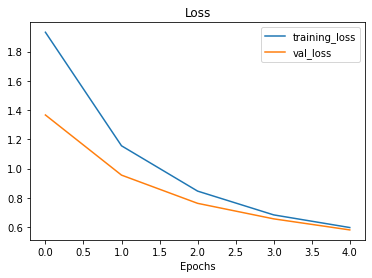

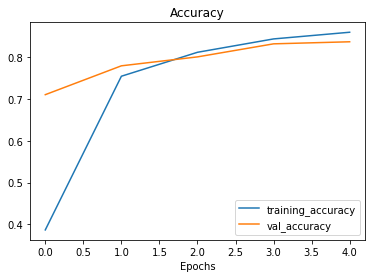

In [14]:
# Check out our model's training curves
plot_loss_curves(history_10_percent)

### Getting a feature vector from a trained model

In [15]:
# Define input tensor shape (same number of dimensions as the output of efficientnetb0)
input_shape = (1, 4, 4, 3)

# Create a random tensor
tf.random.set_seed(42)
input_tensor = tf.random.normal(input_shape)
print(f"Random input tensor:\n {input_tensor}\n")

# Pass the random tensor through a global average pooling 2D layer
global_average_pooled_tensor = tf.keras.layers.GlobalAveragePooling2D()(input_tensor)
print(f"2D global average pooled random tensor:\n {global_average_pooled_tensor}\n")

# Check the shapes of the different tensors
print(f"Shape of input tensor: {input_tensor.shape}")
print(f"Shape of 2D global averaged pooled input tensor: {global_average_pooled_tensor.shape}")

Random input tensor:
 [[[[ 0.3274685  -0.8426258   0.3194337 ]
   [-1.4075519  -2.3880599  -1.0392479 ]
   [-0.5573232   0.539707    1.6994323 ]
   [ 0.28893656 -1.5066116  -0.2645474 ]]

  [[-0.59722406 -1.9171132  -0.62044144]
   [ 0.8504023  -0.40604794 -3.0258412 ]
   [ 0.9058464   0.29855987 -0.22561555]
   [-0.7616443  -1.8917141  -0.93847126]]

  [[ 0.77852213 -0.47338897  0.97772694]
   [ 0.24694404  0.20573747 -0.5256233 ]
   [ 0.32410017  0.02545409 -0.10638497]
   [-0.6369475   1.1603122   0.2507359 ]]

  [[-0.41728503  0.4012578  -1.4145443 ]
   [-0.5931857  -1.6617213   0.33567193]
   [ 0.10815629  0.23479682 -0.56668764]
   [-0.35819843  0.88698614  0.52744764]]]]

2D global average pooled random tensor:
 [[-0.09368646 -0.45840448 -0.2885598 ]]

Shape of input tensor: (1, 4, 4, 3)
Shape of 2D global averaged pooled input tensor: (1, 3)


In [16]:
# This is the same as GlobalAveragePooling2D()
tf.reduce_mean(input_tensor, axis=[1, 2]) # average across the middle axes

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[-0.09368646, -0.45840448, -0.2885598 ]], dtype=float32)>

## Model_1: 1% data with data augmentation

In [17]:
# Download and unzip data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
unzip_data("10_food_classes_1_percent.zip")

# Create training and test dirs
train_dir_1_percent = "10_food_classes_1_percent/train/"
test_dir = "10_food_classes_1_percent/test/"

--2022-05-02 18:02:34--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.192.128, 209.85.145.128, 172.217.219.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.192.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133612354 (127M) [application/zip]
Saving to: ‘10_food_classes_1_percent.zip’

10_food_classes_1_p 100%[===================>] 127.42M   101MB/s    in 1.3s    

2022-05-02 18:02:35 (101 MB/s) - ‘10_food_classes_1_percent.zip’ saved [133612354/133612354]



In [18]:
# Load our images to `tf.data.Dataset` objects
import tensorflow as tf
IMG_SIZE = (224, 224)
train_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_1_percent,
                                                                           label_mode="categorical",
                                                                           batch_size=32, # default
                                                                           image_size=IMG_SIZE)
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE)

Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


### Add data augmentation

In [27]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

# Create a data augmentation stage with horizontal flipping, rotations, zooms
data_augmentation = keras.Sequential([
  preprocessing.RandomFlip("horizontal"),
  preprocessing.RandomRotation(0.2),
  preprocessing.RandomZoom(0.2),
  preprocessing.RandomHeight(0.2),
  preprocessing.RandomWidth(0.2),
  # preprocessing.Rescaling(1./255) # keep for ResNet50V2, remove for EfficientNetB0
], name ="data_augmentation")

### Random Image

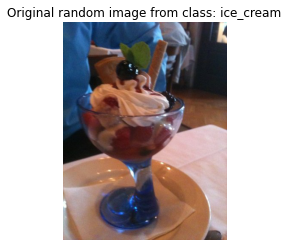

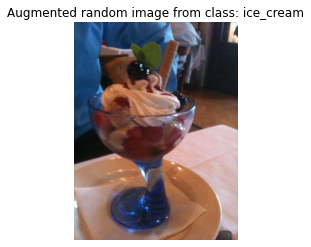

In [26]:
# View a random image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random
target_class = random.choice(train_data_1_percent.class_names) # choose a random class
target_dir = "10_food_classes_1_percent/train/" + target_class # create the target directory
random_image = random.choice(os.listdir(target_dir)) # choose a random image from target directory
random_image_path = target_dir + "/" + random_image # create the choosen random image path
img = mpimg.imread(random_image_path) # read in the chosen target image
plt.imshow(img) # plot the target image
plt.title(f"Original random image from class: {target_class}")
plt.axis(False); # turn off the axes

# Augment the image
augmented_img = data_augmentation(tf.expand_dims(img, axis=0)) # data augmentation model requires shape (None, height, width, 3)
plt.figure()
plt.imshow(tf.squeeze(augmented_img)/255.) # requires normalization after augmentation
plt.title(f"Augmented random image from class: {target_class}")
plt.axis(False);

### Feauture extraction transfer learning model on 1% of the data with data augmentation

In [30]:
# Setup input shape and base model, freezing the base model layers
input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Create input layer
inputs = layers.Input(shape=input_shape, name="input_layer")

# Add in data augmentation Sequential Model as a layer
x = data_augmentation(inputs)

# Give base_model inputs and don't train it
x = base_model(x, training=False)

# Pool output features of base model
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)

# Put a desne layer on as the output
outputs = layers.Dense(10, activation='softmax', name="output_layer")(x)

# Make a model with inputs and outputs
model_1 = keras.Model(inputs, outputs)

# Compile the model
model_1.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Fit the model
history_1_percent = model_1.fit(train_data_1_percent,
                                epochs=5,
                                steps_per_epoch=len(train_data_1_percent),
                                validation_data=test_data,
                                validation_steps=int(0.25*len(test_data)),
                                # Track model training logs
                                callbacks=[create_tensorboard_callback("transfer_learning", "1_percent_data_aug")])

Saving TensorBoard log files to: transfer_learning/1_percent_data_aug/20220502-181552
Epoch 1/5
3/3 [==============================] - 21s 4s/step - loss: 2.4135 - accuracy: 0.0714 - val_loss: 2.2039 - val_accuracy: 0.1941
Epoch 2/5
3/3 [==============================] - 7s 3s/step - loss: 2.1320 - accuracy: 0.2429 - val_loss: 2.0865 - val_accuracy: 0.2401
Epoch 3/5
3/3 [==============================] - 7s 3s/step - loss: 1.9458 - accuracy: 0.4571 - val_loss: 1.9734 - val_accuracy: 0.3372
Epoch 4/5
3/3 [==============================] - 5s 2s/step - loss: 1.8026 - accuracy: 0.5714 - val_loss: 1.8873 - val_accuracy: 0.3997
Epoch 5/5
3/3 [==============================] - 7s 3s/step - loss: 1.6450 - accuracy: 0.6571 - val_loss: 1.7920 - val_accuracy: 0.4638


In [31]:
# Check out model summary
model_1.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, 224, 224, 3)      0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-traina

In [32]:
# Evaluate on the test data
results_1_percent_data_aug = model_1.evaluate(test_data)
results_1_percent_data_aug


79/79 [==============================] - 12s 144ms/step - loss: 1.8088 - accuracy: 0.4632


[1.8088277578353882, 0.46320000290870667]

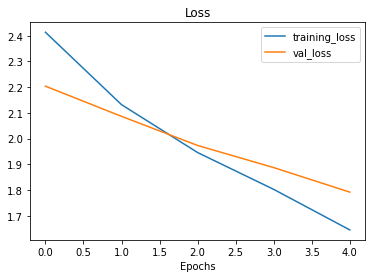

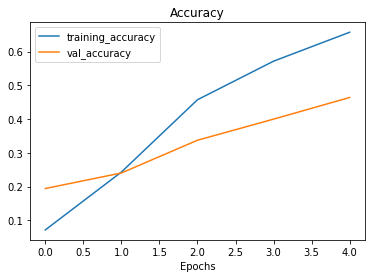

In [33]:
# How does the model go with a data augmentation layer with 1% of data
plot_loss_curves(history_1_percent)

### Creating a ModelCheckpoint callback

In [34]:
# Setup checkpoint path
checkpoint_path = "ten_percent_model_checkpoints_weights/checkpoint.ckpt"

# Create a ModelCheckpoint callback that saves the model's weights only
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                         save_weights_only=True, # set to False to save the entire model
                                                         save_best_only=False,
                                                         save_freq="epoch", # save every epoch
                                                         verbose=1)

# Fit the model saving checkpoints every epoch
initial_epochs = 5
history_10_percent_data_aug = model_1.fit(train_data_1_percent,
                                          epochs=initial_epochs,
                                          validation_data=test_data,
                                          validation_steps=int(0.25 * len(test_data)), # do less steps per validation (quicker)
                                          callbacks=[create_tensorboard_callback("transfer_learning", "10_percent_data_aug"), 
                                                     checkpoint_callback])

Saving TensorBoard log files to: transfer_learning/10_percent_data_aug/20220502-184111
Epoch 1/5
3/3 [==============================] - ETA: 0s - loss: 1.5354 - accuracy: 0.6714
Epoch 1: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
3/3 [==============================] - 8s 3s/step - loss: 1.5354 - accuracy: 0.6714 - val_loss: 1.7026 - val_accuracy: 0.5247
Epoch 2/5
3/3 [==============================] - ETA: 0s - loss: 1.3837 - accuracy: 0.7857
Epoch 2: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
3/3 [==============================] - 7s 3s/step - loss: 1.3837 - accuracy: 0.7857 - val_loss: 1.6171 - val_accuracy: 0.5609
Epoch 3/5
3/3 [==============================] - ETA: 0s - loss: 1.2851 - accuracy: 0.8143
Epoch 3: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
3/3 [==============================] - 5s 2s/step - loss: 1.2851 - accuracy: 0.8143 - val_loss: 1.5690 - val_accuracy: 0.5839
Epoch 4/5
3/3 [==========

## Model 3: Fine-tuning an existing models on 10% of the data

In [35]:
for layer in model_1.layers:
  print(layer.trainable)

True
True
False
True
True


In [36]:
model_1.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, 224, 224, 3)      0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-traina

In [37]:
# How many layers are trainable in our base model?
print(len(model_1.layers[2].trainable_variables))

0


For fine-tune the base model to our own data, we're going to unfreeze the top 10 layers and continue training our model for another 5 epochs.

This means all of the base model's layers except for the last 10 will remain frozen and untrainable. And the weights in the remaining unfrozen layers will be updated during training.

To begin fine-tuning, we'll unfreeze the entire base model by setting its trainable attribute to True. Then we'll refreeze every layer in the base model except for the last 10 by looping through them and setting their trainable attribute to False. Finally, we'll recompile the model.

In [39]:
base_model.trainable = True

# Freeze all layers exceptfor the 
for layer in base_model.layers[:-10]:
  layer.trainable = False

# Recompile the model (always recompile after any adjustments to a model)
model_1.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(learning_rate=.0001),
                metrics=["accuracy"])

In [40]:
print(len(model_1.trainable_variables))

12


In [46]:
# Fine tune for another 5 epochs
fine_tune_epochs = initial_epochs + 5

# Refit the model (same as before with more trainable layers)
history_fine_1_percent_data_aug = model_1.fit(train_data_1_percent,
                                              epochs=fine_tune_epochs,
                                              validation_data=test_data,
                                              initial_epoch=history_10_percent_data_aug.epoch[-1],  # start from previous last epoch
                                              validation_steps=int(0.25 * len(test_data)),
                                              callbacks=[create_tensorboard_callback("transfer_learning", "10_percent_fine_tune_last_10")]) 

# Evaluate the model on the test data
results_fine_tune_1_percent = model_1.evaluate(test_data)

Saving TensorBoard log files to: transfer_learning/10_percent_fine_tune_last_10/20220502-190907
Epoch 5/10
3/3 [==============================] - 20s 4s/step - loss: 0.9939 - accuracy: 0.9143 - val_loss: 1.3234 - val_accuracy: 0.6908
Epoch 6/10
3/3 [==============================] - 5s 2s/step - loss: 0.8869 - accuracy: 0.9429 - val_loss: 1.2882 - val_accuracy: 0.6826
Epoch 7/10
3/3 [==============================] - 5s 2s/step - loss: 0.7389 - accuracy: 0.9286 - val_loss: 1.2278 - val_accuracy: 0.6891
Epoch 8/10
3/3 [==============================] - 5s 2s/step - loss: 0.7441 - accuracy: 0.9571 - val_loss: 1.1694 - val_accuracy: 0.6941
Epoch 9/10
3/3 [==============================] - 4s 2s/step - loss: 0.5726 - accuracy: 0.9714 - val_loss: 1.1373 - val_accuracy: 0.6974
Epoch 10/10
79/79 [==============================] - 11s 134ms/step - loss: 1.1349 - accuracy: 0.6732


In [47]:
def compare_historys(original_history, new_history, initial_epochs=5):
    """
    Compares two model history objects.
    """
    # Get original history measurements
    acc = original_history.history["accuracy"]
    loss = original_history.history["loss"]

    print(len(acc))

    val_acc = original_history.history["val_accuracy"]
    val_loss = original_history.history["val_loss"]

    # Combine original history with new history
    total_acc = acc + new_history.history["accuracy"]
    total_loss = loss + new_history.history["loss"]

    total_val_acc = val_acc + new_history.history["val_accuracy"]
    total_val_loss = val_loss + new_history.history["val_loss"]

    print(len(total_acc))
    print(total_acc)

    # Make plots
    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(total_acc, label='Training Accuracy')
    plt.plot(total_val_acc, label='Validation Accuracy')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(total_loss, label='Training Loss')
    plt.plot(total_val_loss, label='Validation Loss')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()

5
11
[0.6714285612106323, 0.7857142686843872, 0.8142856955528259, 0.8428571224212646, 0.8571428656578064, 0.9142857193946838, 0.9428571462631226, 0.9285714030265808, 0.9571428298950195, 0.9714285731315613, 0.9428571462631226]


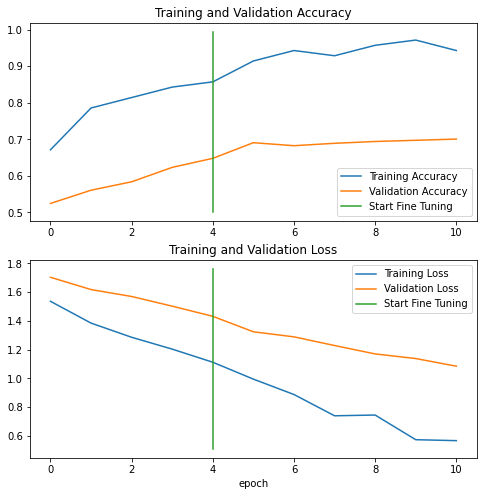

In [49]:
compare_historys(original_history=history_10_percent_data_aug, 
                 new_history=history_fine_1_percent_data_aug, 
                 initial_epochs=5);

In [50]:
model_1.load_weights(checkpoint_path)

In [51]:
# Check which layers are tuneable in the whole model
for layer_number, layer in enumerate(model_1.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_layer True
1 data_augmentation True
2 efficientnetb0 True
3 global_average_pooling_layer True
4 output_layer True
